<a href="https://colab.research.google.com/github/TobiBu/graddays/blob/main/day_2/notebooks/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Autoencoder Example

This is the first file, where a very basic autoencoder is used to reproduce the two moons dataset. Furthermore, a convolutional autoencoder is applied on the MNIST dataset. The 2D latent space is visualised for each label, showing the irregularities of the autoencoder latent space. When trying to generate data, some problems occur, which are then treated in the next notebook.

In [ ]:
!git clone https://github.com/TobiBu/SciML-Seminar.git

Cloning into 'SciML-Seminar'...
remote: Enumerating objects: 242, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 242 (delta 18), reused 35 (delta 12), pack-reused 198 (from 1)
Receiving objects: 100% (242/242), 395.74 MiB | 11.70 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [ ]:
# add folder from the git repo to path to make python modlues importable
import sys
sys.path.append('SciML-Seminar')

In [ ]:
# import pytorch
import torch
import torch.nn as nn
import torch.optim as optim

# import other libraries
import tqdm
import matplotlib.pyplot as plt
import numpy as np

# import specific functions
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from torchvision import datasets, transforms

In [ ]:
# import custom functions
from interpolate import interpolate

In [ ]:
# choose whether to retrain the mnist model and save it or use the saved one
TRAIN = False
SAVE = False

# path to the model saves
PATH = 'SciML-Seminar/models/'

## Define basic Autoencoder class and necessary routines

In [ ]:
# autoencoder skeleton

class Autoencoder(nn.Module):
    def __init__(self, input_size, num_hidden_layers, hidden_layer_size, bottleneck_size):
        super(Autoencoder, self).__init__()

        # define architecture of the autoencoder
        self.input_size = input_size
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layer_size = hidden_layer_size
        self.bottleneck_size = bottleneck_size

        # construct the encoder and decoder
        self.encoder = self.construct_encoder()
        self.decoder = self.construct_decoder()

        # define loss function and optimizer
        self.loss = nn.MSELoss(reduction='mean')
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)

    def construct_encoder(self):
        # construct the encoder
        encoder = nn.Sequential()

        encoder.add_module('input', nn.Linear(self.input_size, self.hidden_layer_size))
        encoder.add_module('relu_input', nn.ReLU())

        for i in range(self.num_hidden_layers - 1):
            encoder.add_module('hidden_' + str(i), nn.Linear(self.hidden_layer_size, self.hidden_layer_size))
            encoder.add_module('relu_' + str(i), nn.ReLU())

        encoder.add_module('bottleneck', nn.Linear(self.hidden_layer_size, self.bottleneck_size))

        return encoder

    def construct_decoder(self):
        # construct the decoder
        decoder = nn.Sequential()

        decoder.add_module('input', nn.Linear(self.bottleneck_size, self.hidden_layer_size))
        decoder.add_module('relu_input', nn.ReLU())

        for i in range(self.num_hidden_layers - 1):
            decoder.add_module('hidden_' + str(i), nn.Linear(self.hidden_layer_size, self.hidden_layer_size))
            decoder.add_module('relu_' + str(i), nn.ReLU())

        decoder.add_module('output', nn.Linear(self.hidden_layer_size, self.input_size))

        return decoder

    def forward(self, x):
        # forward pass
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# define training loop

def train_autoencoder(model, X_train, X_val, n_epochs=10, batch_size=32, verbose=True):
    loss_history = {
        'train': [],
        'val': []
    }

    if verbose:
        pbar = tqdm.tqdm(range(n_epochs))
    else:
        pbar = range(n_epochs)

    for epoch in pbar:
        # training
        model.train()
        train_loss = 0
        for i in tqdm.tqdm(range(0, X_train.shape[0], batch_size)):
            batch = X_train[i:i+batch_size]
            model.optimizer.zero_grad()
            output = model(batch)
            loss = model.loss(output, batch)
            loss.backward()
            model.optimizer.step()
            train_loss += loss.item()
        train_loss /= X_train.shape[0]
        loss_history['train'].append(train_loss)

        # validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for i in range(0, X_val.shape[0], batch_size):
                batch = X_val[i:i+batch_size]
                output = model(batch)
                loss = model.loss(output, batch)
                val_loss += loss.item()
        val_loss /= X_val.shape[0]
        loss_history['val'].append(val_loss)

        # print loss
        if verbose:
            pbar.set_description('Epoch: {}/{}, train loss: {:.4f}, val loss: {:.4f}'.format(epoch+1, n_epochs, train_loss, val_loss))

    return loss_history

In [ ]:
# define function to plot loss history

def plot_loss_history(loss_history):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    epochs_linspace = np.linspace(1, len(loss_history['train']), len(loss_history['train']))

    ax.scatter(epochs_linspace, loss_history['train'], label='train loss', marker='o')
    ax.scatter(epochs_linspace, loss_history['val'], label='val loss', marker='x')

    ax.plot(epochs_linspace, loss_history['train'])
    ax.plot(epochs_linspace, loss_history['val'])

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

    ax.set_yscale('log')

    ax.grid(alpha=0.35)
    ax.legend()

## Use the Autoencoder for a 2D dataset

In [ ]:
dataset_size = 5000

# load data

dataset = make_moons(n_samples=dataset_size, noise=0.1)[0]

# split data into train and validation sets

X_train, X_val = train_test_split(dataset, test_size=0.2)
X_val, X_test = train_test_split(X_val, test_size=0.5)

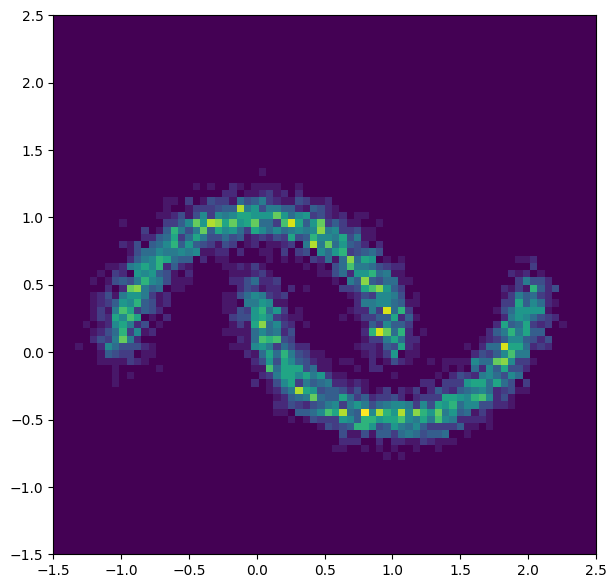

In [ ]:
# visualise data as density plot

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.hist2d(dataset[:, 0], dataset[:, 1], bins=np.linspace(-1.5, 2.5, 75));

In [ ]:
# architecture of a basic autoencoder

INPUT_SIZE = 2
BOTTLENECK_SIZE = 1
HIDDEN_SIZE = 64
HIDDEN_LAYERS = 4

autoencoder_moons = Autoencoder(INPUT_SIZE, HIDDEN_LAYERS, HIDDEN_SIZE, BOTTLENECK_SIZE)

100%|██████████| 125/125 [00:00<00:00, 138.18it/s]
Epoch: 1/25, train loss: 0.0064, val loss: 0.0019:   4%|▍         | 1/25 [00:00<00:22,  1.08it/s]
100%|██████████| 125/125 [00:00<00:00, 183.24it/s]
Epoch: 2/25, train loss: 0.0016, val loss: 0.0012:   8%|▊         | 2/25 [00:01<00:18,  1.25it/s]
100%|██████████| 125/125 [00:00<00:00, 247.78it/s]
Epoch: 3/25, train loss: 0.0011, val loss: 0.0011:  12%|█▏        | 3/25 [00:02<00:14,  1.48it/s]
100%|██████████| 125/125 [00:00<00:00, 265.09it/s]
Epoch: 4/25, train loss: 0.0009, val loss: 0.0009:  16%|█▌        | 4/25 [00:02<00:12,  1.66it/s]
100%|██████████| 125/125 [00:00<00:00, 244.98it/s]
Epoch: 5/25, train loss: 0.0008, val loss: 0.0007:  20%|██        | 5/25 [00:03<00:11,  1.73it/s]
100%|██████████| 125/125 [00:00<00:00, 230.46it/s]
Epoch: 6/25, train loss: 0.0006, val loss: 0.0007:  24%|██▍       | 6/25 [00:03<00:10,  1.74it/s]
100%|██████████| 125/125 [00:00<00:00, 228.44it/s]
Epoch: 7/25, train loss: 0.0004, val loss: 0.0005:  28%

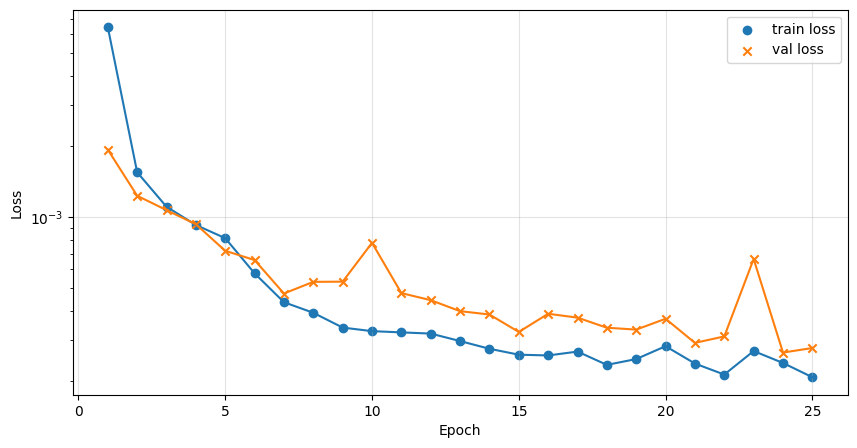

In [ ]:
# train autoencoder on the moon dataset

loss_history_moons = train_autoencoder(autoencoder_moons, torch.Tensor(X_train), torch.Tensor(X_val), n_epochs=25, batch_size=32)

# plot loss history

plot_loss_history(loss_history_moons)

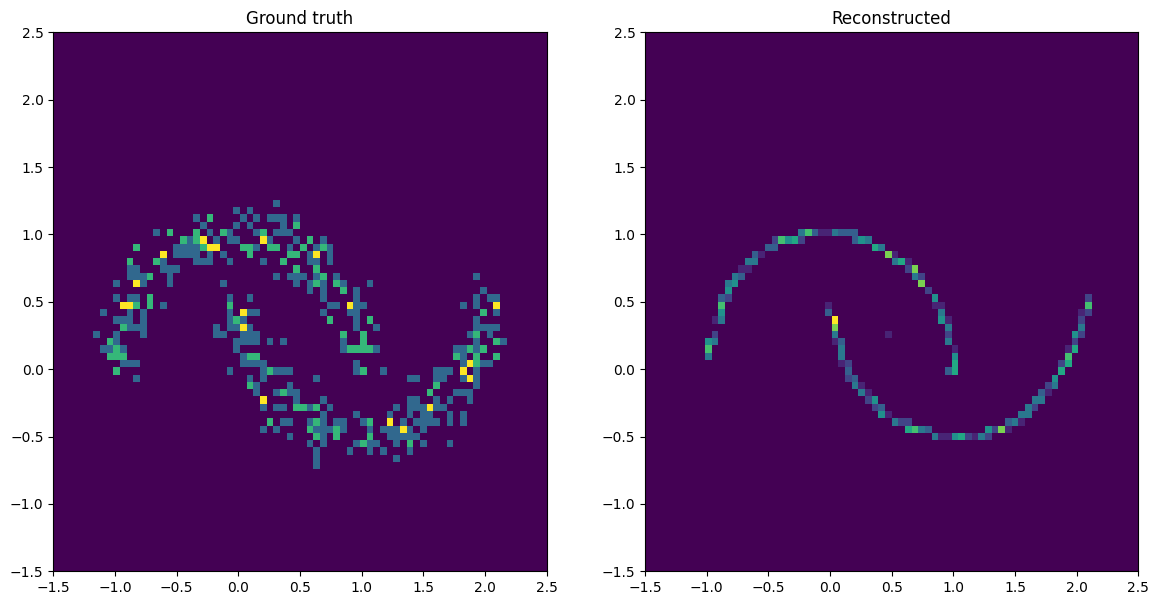

In [ ]:
# compare ground truth and reconstructed data of test set
autoencoder_moons.eval()
reconstructed_moons = autoencoder_moons(torch.Tensor(X_test)).detach().numpy()

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

ax[0].hist2d(X_test[:, 0], X_test[:, 1], bins=np.linspace(-1.5, 2.5, 75))
ax[0].set_title('Ground truth')

ax[1].hist2d(reconstructed_moons[:, 0], reconstructed_moons[:, 1], bins=np.linspace(-1.5, 2.5, 75))
ax[1].set_title('Reconstructed');

## More complex example: MNIST

In [ ]:
# define convolutional autoencoder

class ConvAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_hidden_layers, bottleneck_size):
        super(ConvAutoencoder, self).__init__()

        # define architecture of the autoencoder
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.num_hidden_layers = num_hidden_layers
        self.bottleneck_size = bottleneck_size

        self.mnist_size = 28

        # construct the encoder and decoder
        self.encoder = self.construct_encoder()
        self.decoder = self.construct_decoder()

        # define loss function and optimizer
        self.loss = nn.MSELoss(reduction='mean')
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)

    def construct_encoder(self):
        # construct the encoder
        encoder = nn.Sequential()

        encoder.add_module('input', nn.Conv2d(self.input_size, self.hidden_layer_size, kernel_size=3, stride=1, padding=1))
        encoder.add_module('relu_input', nn.ReLU())

        for i in range(self.num_hidden_layers - 1):
            encoder.add_module('hidden_' + str(i), nn.Conv2d(self.hidden_layer_size, self.hidden_layer_size, kernel_size=3, stride=1, padding=1))
            encoder.add_module('relu_' + str(i), nn.ReLU())

        # dense bottleneck layer
        encoder.add_module('flatten', nn.Flatten())
        encoder.add_module('bottleneck', nn.Linear(self.hidden_layer_size * self.mnist_size *self.mnist_size, self.bottleneck_size))

        return encoder

    def construct_decoder(self):
        # construct the decoder
        decoder = nn.Sequential()

        decoder.add_module('input', nn.Linear(self.bottleneck_size, self.hidden_layer_size * self.mnist_size * self.mnist_size))
        decoder.add_module('reshape', nn.Unflatten(1, (self.hidden_layer_size, self.mnist_size, self.mnist_size)))
        decoder.add_module('relu_input', nn.ReLU())

        for i in range(self.num_hidden_layers - 1):
            decoder.add_module('hidden_' + str(i), nn.Conv2d(self.hidden_layer_size, self.hidden_layer_size, kernel_size=3, stride=1, padding=1))
            decoder.add_module('relu_' + str(i), nn.ReLU())

        decoder.add_module('output', nn.Conv2d(self.hidden_layer_size, self.input_size, kernel_size=3, stride=1, padding=1))

        return decoder

    def forward(self, x):
        # forward pass
        x = self.encoder(x)
        x = self.decoder(x)
        return x


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 54968442.43it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1817762.51it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3572529.21it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3329347.91it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



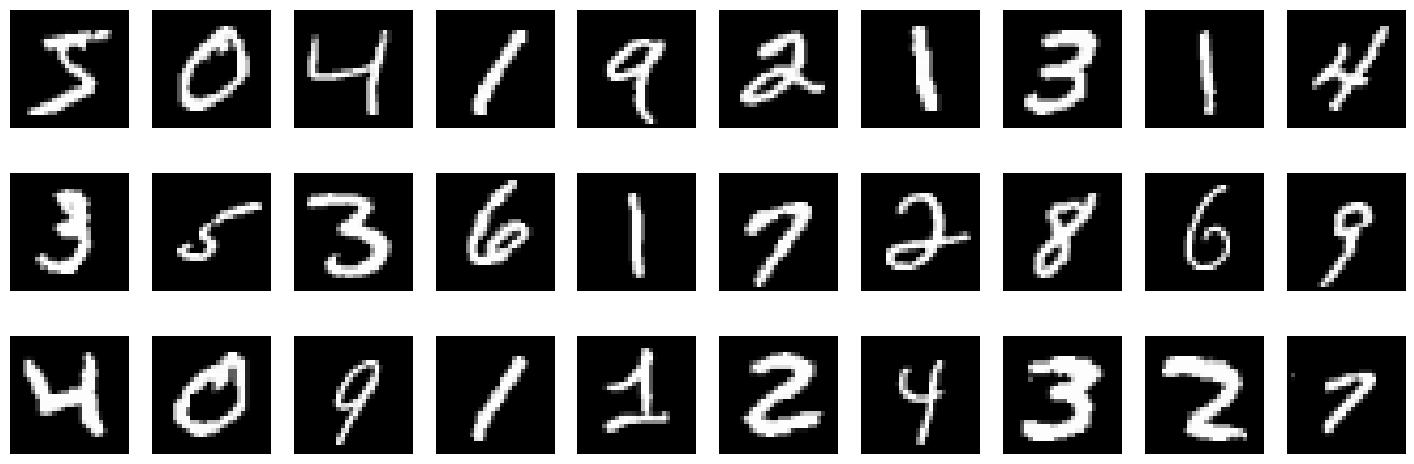

In [ ]:
# get MNIST dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

mnist_test_data, mnist_val_data = train_test_split(mnist_test_data, test_size=0.5)

mnist_train = torch.stack([x for x, _ in mnist_train_data])
mnist_test = torch.stack([x for x, _ in mnist_test_data])
mnist_val = torch.stack([x for x, _ in mnist_val_data])

mnist_test_labels = torch.Tensor([y for _, y in mnist_test_data])

# visualise data

fig, ax = plt.subplots(3, 10, figsize=(18, 6))

for i in range(3):
    for j in range(10):
        ax[i, j].imshow(mnist_train[i*10 + j].squeeze(), cmap='gray')
        ax[i, j].axis('off')


<ipython-input-17-d7b725794e1b>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  conv_autoencoder_mnist.load_state_dict(torch.load(PATH + 'conv_autoencoder_mnist.pt'))


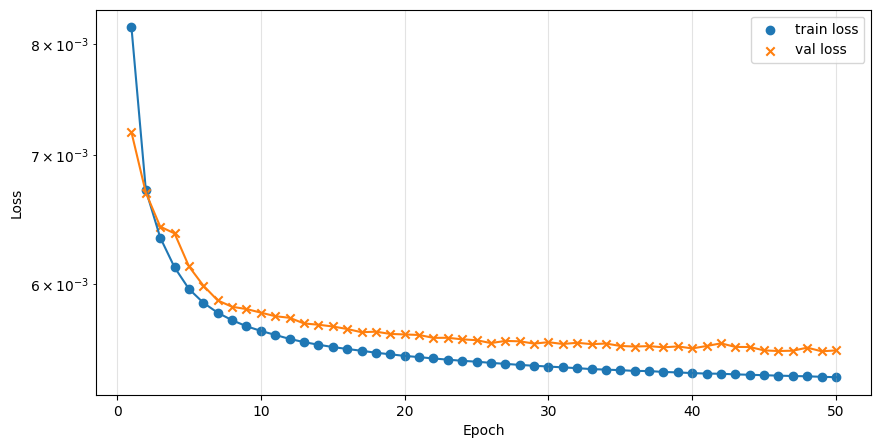

In [ ]:
# train autoencoder on MNIST dataset

INPUT_SIZE = 1
BOTTLENECK_SIZE = 2
HIDDEN_SIZE = 4
HIDDEN_LAYERS = 3


if TRAIN:
    conv_autoencoder_mnist = ConvAutoencoder(INPUT_SIZE, HIDDEN_SIZE, HIDDEN_LAYERS, BOTTLENECK_SIZE)
    loss_history_mnist = train_autoencoder(conv_autoencoder_mnist, mnist_train, mnist_val, n_epochs=50, batch_size=32)
    plot_loss_history(loss_history_mnist)
    if SAVE:
        torch.save(conv_autoencoder_mnist.state_dict(), PATH + 'conv_autoencoder_mnist.pt')
        np.save(PATH + 'loss_history_mnist.npy', loss_history_mnist)

else:
    # load pretrained model
    conv_autoencoder_mnist = ConvAutoencoder(INPUT_SIZE, HIDDEN_SIZE, HIDDEN_LAYERS, BOTTLENECK_SIZE)
    conv_autoencoder_mnist.load_state_dict(torch.load(PATH + 'conv_autoencoder_mnist.pt'))
    loss_history_mnist = np.load(PATH + 'loss_history_mnist.npy', allow_pickle=True).item()
    plot_loss_history(loss_history_mnist)

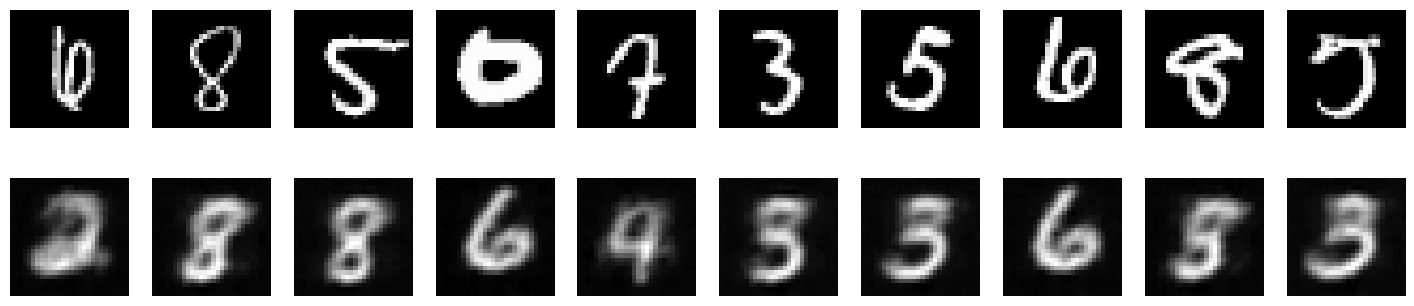

In [ ]:
# look at reconstructions of test set

reconstructed_mnist = conv_autoencoder_mnist(mnist_test).detach().numpy()

# compare ground truth and reconstructed data

fig, ax = plt.subplots(2, 10, figsize=(18, 4))

for i in range(10):
    ax[0, i].imshow(mnist_test[i].squeeze(), cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(reconstructed_mnist[i].squeeze(), cmap='gray')
    ax[1, i].axis('off')


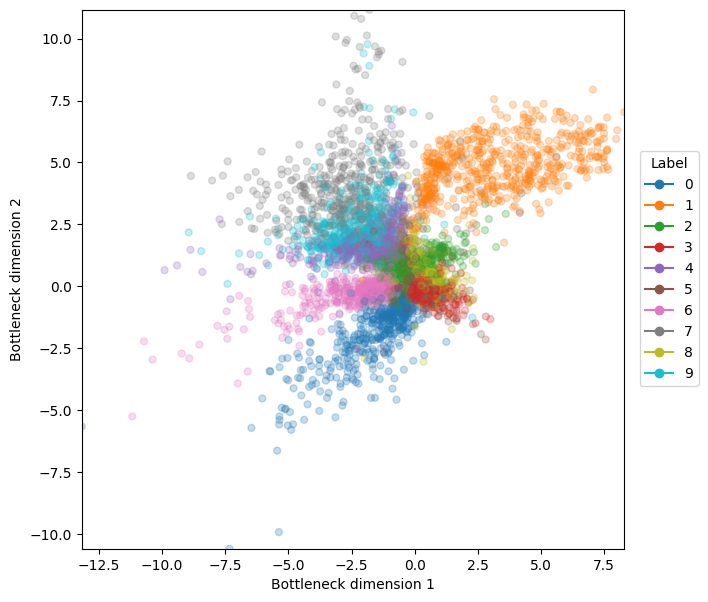

In [ ]:
# visualise bottleneck layer with respect to the labels

bottleneck_mnist = conv_autoencoder_mnist.encoder(mnist_test).detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.scatter(bottleneck_mnist[:, 0], bottleneck_mnist[:, 1], c=mnist_test_labels[:], cmap='tab10', alpha=0.25, marker='.', s=100)

ax.set_xlabel('Bottleneck dimension 1')
ax.set_ylabel('Bottleneck dimension 2')

legend_handeles = []
for i in range(10):
    legend_handeles.append(plt.Line2D([0], [0], marker='o', color=plt.cm.tab10.colors[i], label=str(i)))

ax.legend(handles=legend_handeles, title='Label', loc='upper right', bbox_to_anchor=(1.15, 0.75))

ax.set_xlim([np.min(bottleneck_mnist[:, 0]), np.max(bottleneck_mnist[:, 0])])
ax.set_ylim([np.min(bottleneck_mnist[:, 1]), np.max(bottleneck_mnist[:, 1])]);

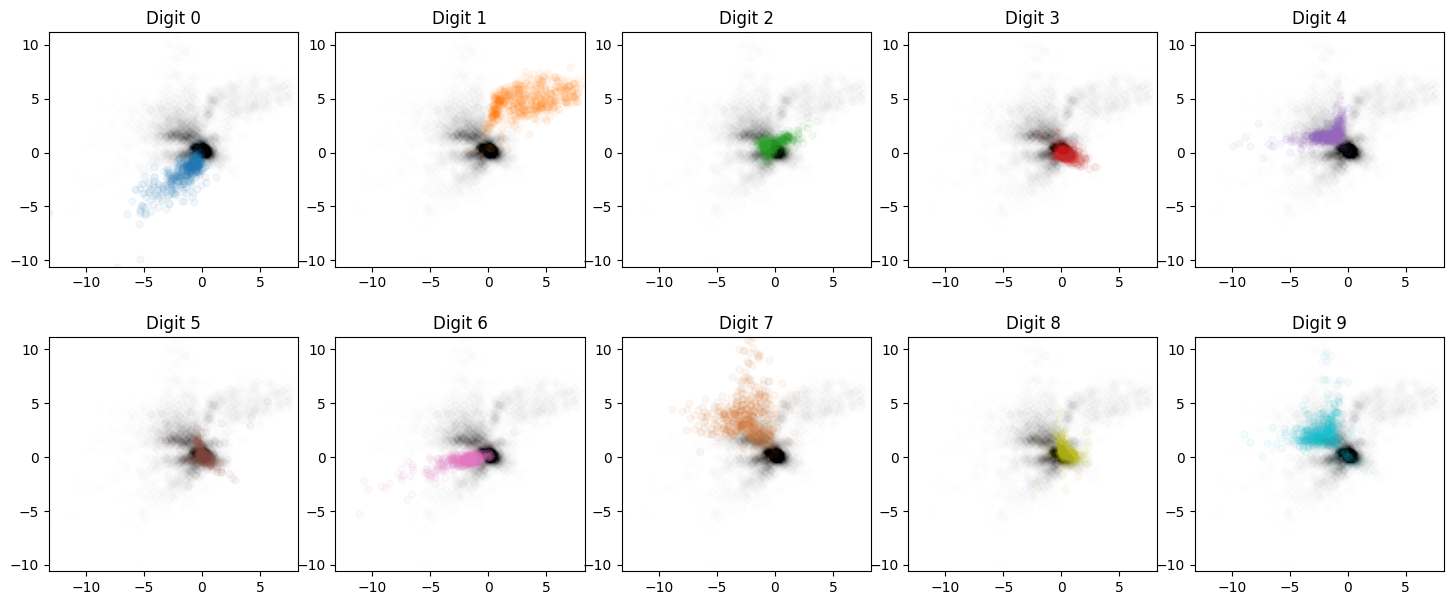

In [ ]:
# make subplots for each digit

fig, ax = plt.subplots(2, 5, figsize=(18, 7))

for i in range(10):
    for j in range(10):
        if j != i:
            ax[i//5, i%5].scatter(bottleneck_mnist[mnist_test_labels == j, 0], bottleneck_mnist[mnist_test_labels == j, 1], color='black', alpha=0.005, marker='.', s=100)

    if i != 7:
        ax[i//5, i%5].scatter(bottleneck_mnist[mnist_test_labels == i, 0], bottleneck_mnist[mnist_test_labels == i, 1], color=plt.cm.tab10.colors[i], alpha=0.05, marker='.', s=100)
        ax[i//5, i%5].set_title('Digit {}'.format(i))
    else:
        ax[i//5, i%5].scatter(bottleneck_mnist[mnist_test_labels == i, 0], bottleneck_mnist[mnist_test_labels == i, 1], color='chocolate', alpha=0.05, marker='.', s=100)
        ax[i//5, i%5].set_title('Digit {}'.format(i))

    ax[i//5, i%5].set_xlim([np.min(bottleneck_mnist[:, 0]), np.max(bottleneck_mnist[:, 0])])
    ax[i//5, i%5].set_ylim([np.min(bottleneck_mnist[:, 1]), np.max(bottleneck_mnist[:, 1])])

    fig.subplots_adjust(hspace=0.3)
    fig.subplots_adjust(wspace=0.15)


# So, what about data generation?

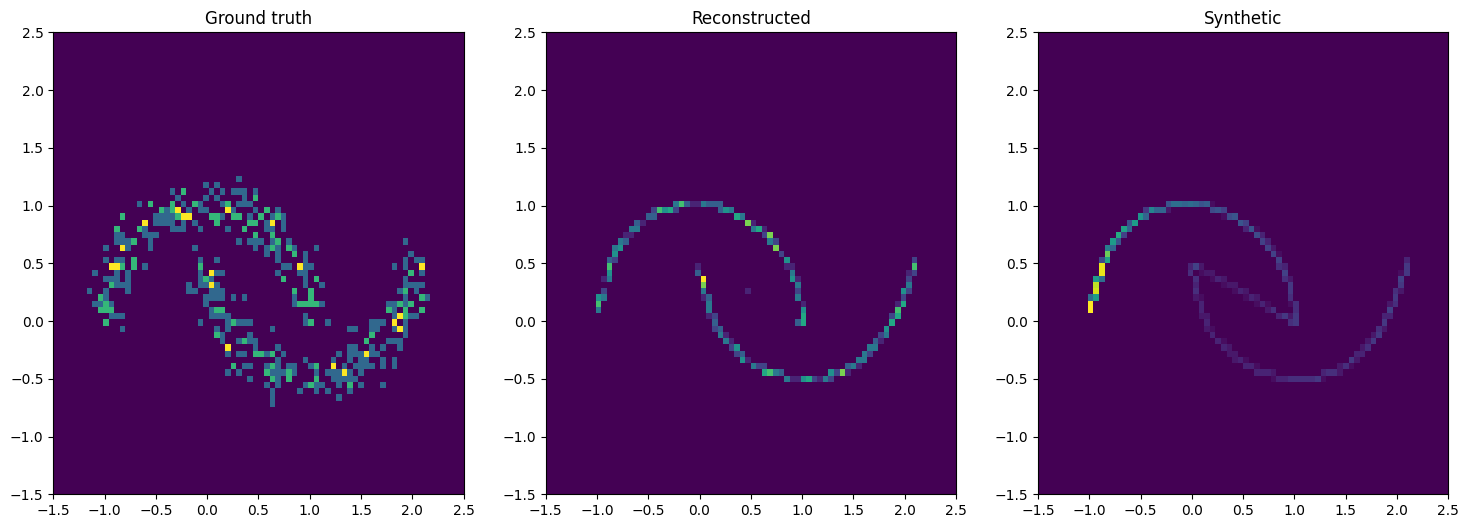

In [ ]:
# extract min and max bottleneck values for the moon dataset

bottleneck_moons = autoencoder_moons.encoder(torch.Tensor(X_test)).detach().numpy()

min_bottleneck_moons = np.min(bottleneck_moons, axis=0)
max_bottleneck_moons = np.max(bottleneck_moons, axis=0)

# uniform spaced sampling from the bottleneck space

n_samples = 1000

bottleneck_samples = np.linspace(min_bottleneck_moons, max_bottleneck_moons, n_samples)

# reconstruct samples

reconstructed_samples = autoencoder_moons.decoder(torch.Tensor(bottleneck_samples)).detach().numpy()

# plot ground truth, reconstructions and synthetic data

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].hist2d(X_test[:, 0], X_test[:, 1], bins=np.linspace(-1.5, 2.5, 75))
ax[0].set_title('Ground truth')

ax[1].hist2d(reconstructed_moons[:, 0], reconstructed_moons[:, 1], bins=np.linspace(-1.5, 2.5, 75))
ax[1].set_title('Reconstructed')

ax[2].hist2d(reconstructed_samples[:, 0], reconstructed_samples[:, 1], bins=np.linspace(-1.5, 2.5, 75))
ax[2].set_title('Synthetic');

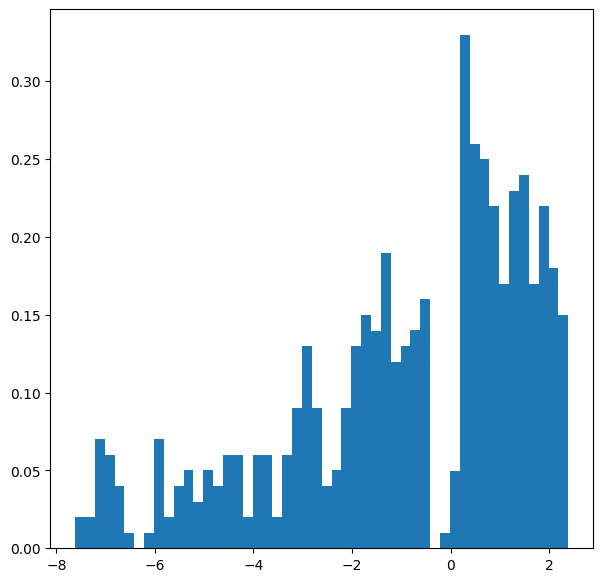

In [ ]:
# take a look at the 1D bottleneck of the moon dataset

bottleneck_moons = autoencoder_moons.encoder(torch.Tensor(X_test)).detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.hist(bottleneck_moons, bins=50, color='tab:blue', density=True);

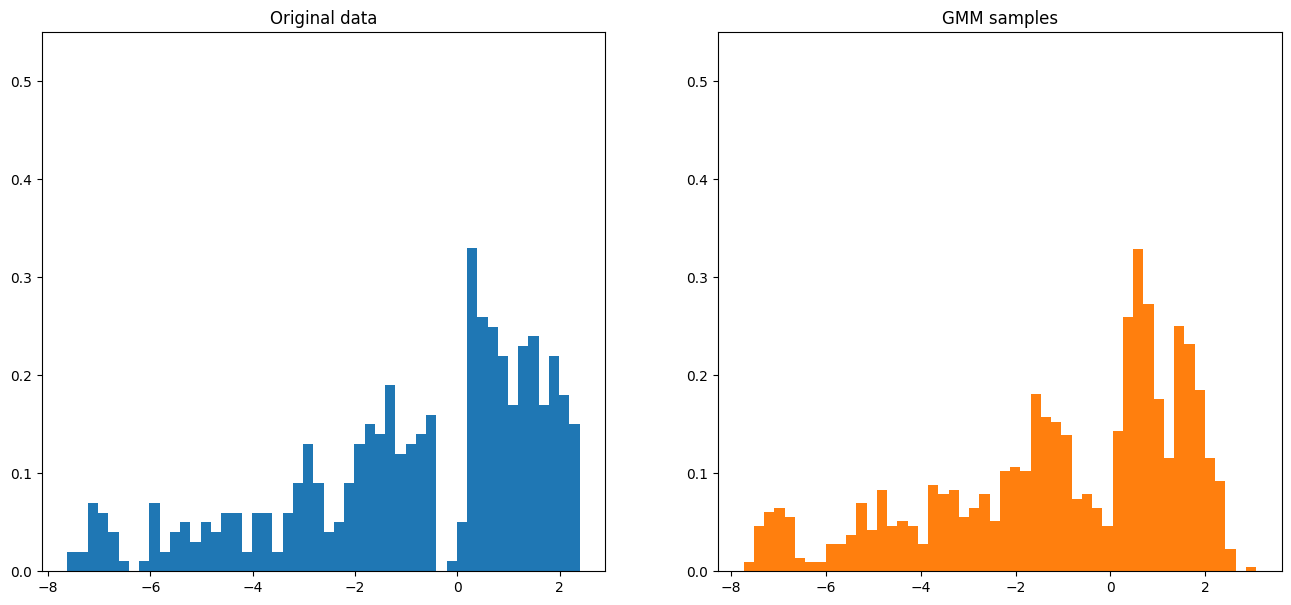

In [ ]:
# and fit a Gaussian mixture model to it

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=6, covariance_type='full')

gmm.fit(bottleneck_moons)

# plot the original data and the samples from the GMM

fig, ax = plt.subplots(1, 2, figsize=(16, 7))

ax[0].hist(bottleneck_moons, bins=50, color='tab:blue', density=True)
ax[0].set_ylim(0, 0.55)
ax[0].set_title('Original data')

ax[1].hist(gmm.sample(1000)[0], bins=50, color='tab:orange', density=True)
ax[1].set_ylim(0, 0.55)
ax[1].set_title('GMM samples');

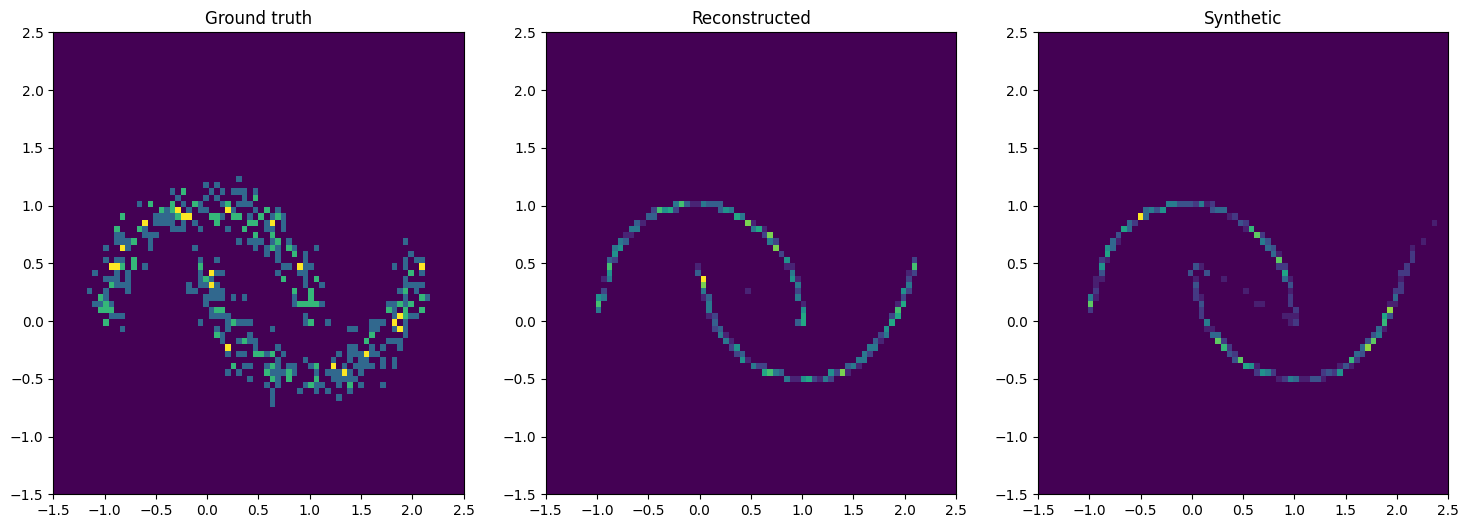

In [ ]:
# sample from the GMM and decode the samples

samples = gmm.sample(len(X_test))[0]

samples = torch.Tensor(samples)

generated_samples = autoencoder_moons.decoder(samples).detach().numpy()

# plot the ground truth, reconstructions an sythetic data

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].hist2d(X_test[:, 0], X_test[:, 1], bins=np.linspace(-1.5, 2.5, 75))
ax[0].set_title('Ground truth')

ax[1].hist2d(reconstructed_moons[:, 0], reconstructed_moons[:, 1], bins=np.linspace(-1.5, 2.5, 75))
ax[1].set_title('Reconstructed')

ax[2].hist2d(generated_samples[:, 0], generated_samples[:, 1], bins=np.linspace(-1.5, 2.5, 75))
ax[2].set_title('Synthetic');

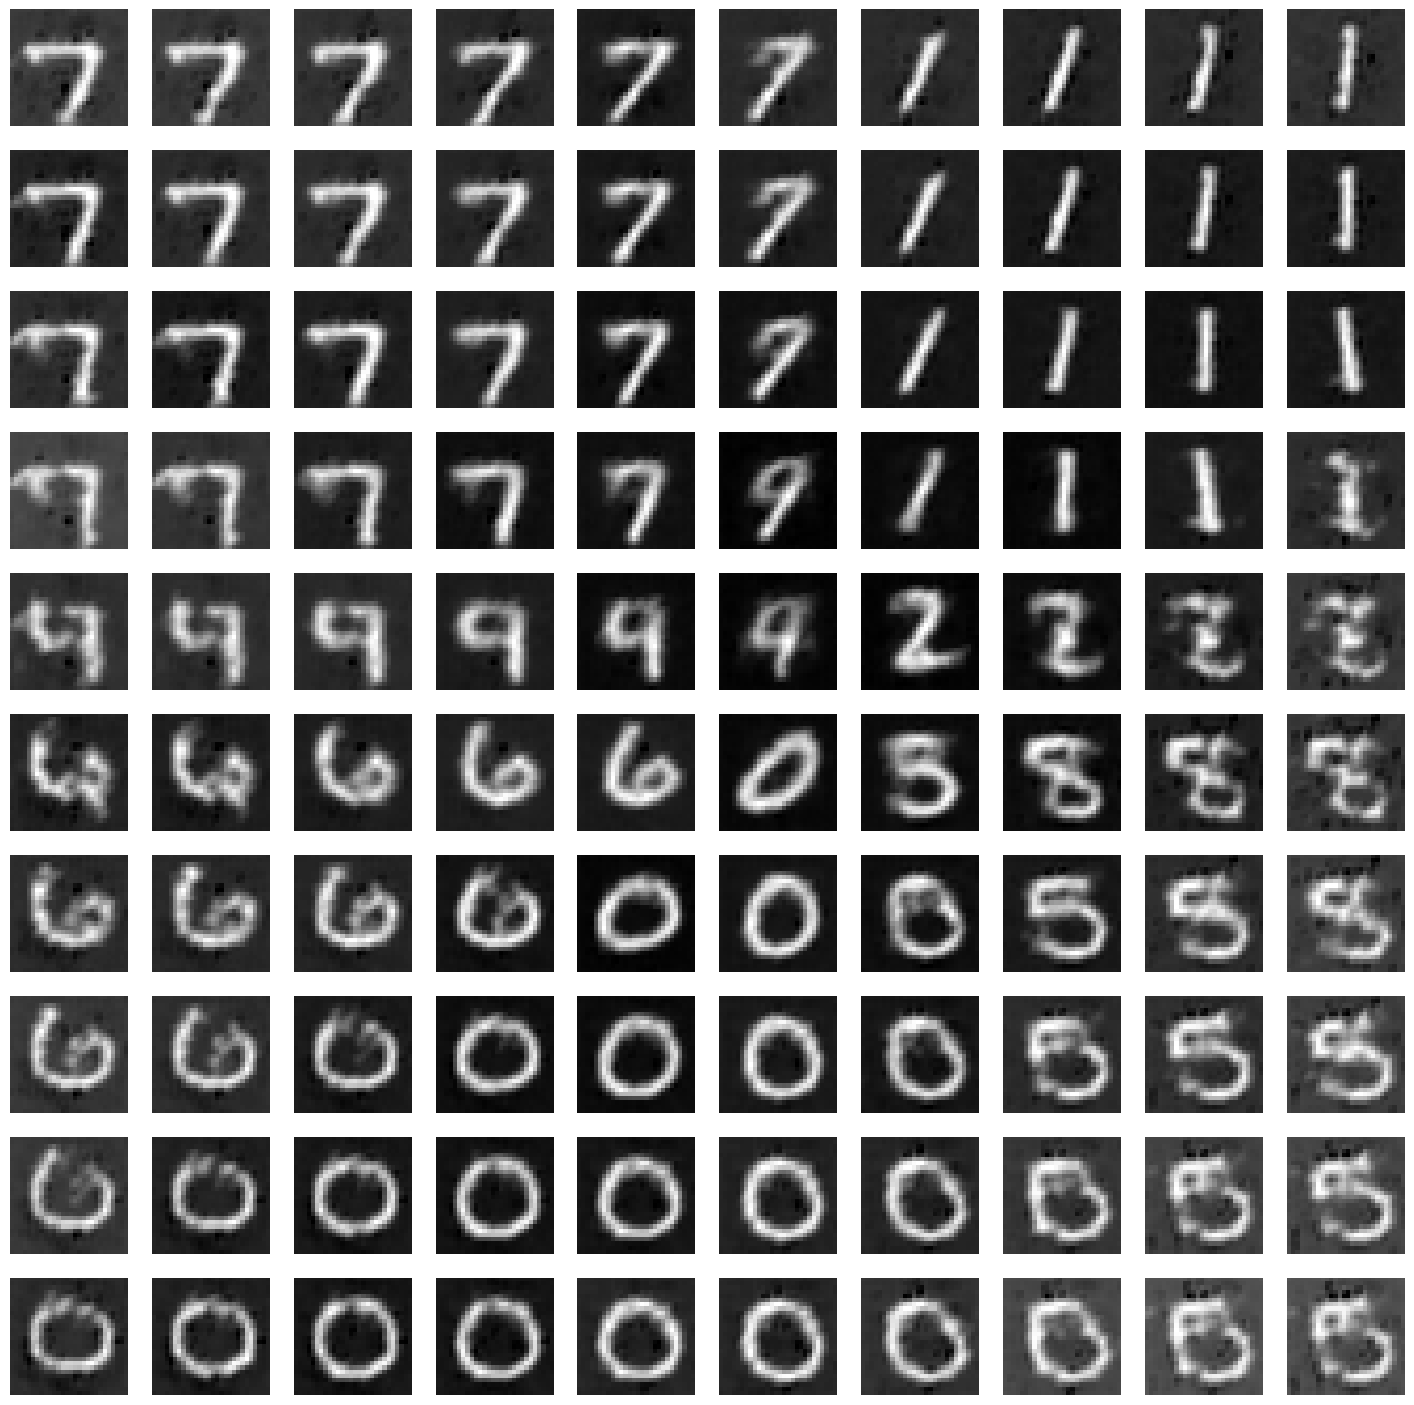

In [ ]:
# For MNIST:
# generate 100 samples in a grid from min to max in both dimensions

x_min = np.min(bottleneck_mnist[:, 0])
x_max = np.max(bottleneck_mnist[:, 0])

y_min = np.min(bottleneck_mnist[:, 1])
y_max = np.max(bottleneck_mnist[:, 1])

x = np.linspace(x_min, x_max, 10)
y = np.linspace(y_min, y_max, 10)


grid = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)

# generate samples from the grid

grid = torch.Tensor(grid)
with torch.no_grad():
    grid_recon = conv_autoencoder_mnist.decoder(grid)

grid_recon = grid_recon.detach().numpy()

grid_recon = grid_recon.reshape(10, 10, 28, 28)

# plot the grid

fig, ax = plt.subplots(10, 10, figsize=(18, 18))

for i in range(10):
    for j in range(10):
        ax[i, j].imshow(grid_recon[j, 9 - i].squeeze(), cmap='gray')
        ax[i, j].axis('off')
